### Getting insight into driving factors of ion-mobility

Recent papers that worked on ion-mobility prediction such as Chang et al.1 and Meier et al.2 identified factors that drive differences in ion mobility. By using an in silico digest of the human proteome, we will now visit two of them, namely the gravy score and helicality of peptides. We will start at an initial guess about an ions ccs value, derived from the simple formula: 

$CCS_i(mz, c) = s_c \times \sqrt{mz} + b_c$ 

Where a slope $s_c$ and an intercept $b_c$ are fit separately for each modeled charge state $c$. The reason why ion-mobility does add an additional dimension of separation is the fact that an ion's CCS value does not always lie on that line. If it did, CCS would be perfectly correlated with m/z and therefore add no new information. The idea is now to look at the residues with respect to the square root fit, meaning the vertical difference to our initial guess. This residue could be provided by any predictor. We will look at our best performing one: the GRU-based predictor. It is based on deep GRU-units that can take into account sequence specific higher-order information derived from training data. We will expand our mathematical formulation of the problem as follows:

$ \mathrm{CCS}_{\mathrm{final}}(\mathrm{mz}, c, s \vert M ) = \mathrm{CCS}_{\mathrm{init}}(\mathrm{mz}, c) + M(s, \theta)$

Here, a regressor $M$ (GRU-units) with parameter set $\theta$ was fit to further lower the mean absolut error (MAE) of predicted CCS values compared to the experimentally observed ones. For convenience, this predictor does not only return the final predicted ccs value but also the residue with respect to the initial fit, giving us an easy way to link specific features of a given sequence to its impact on ion mobility.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import os
# suppress CUDA logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

gpus = tf.config.experimental.list_physical_devices('GPU')

#tf.config.experimental.set_virtual_device_configuration(gpus[0], 
#                    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

from matplotlib import pyplot as plt
from ionmob.preprocess.helpers import get_gravy_score, get_helix_score
from ionmob.preprocess.helpers import tokenizer_from_json
from ionmob.preprocess.data import sqrt_model_dataset, to_tf_dataset_inference

In [2]:
data = pd.read_parquet('../data/synthetic.parquet').sample(frac=0.25)
data.head()

,sequence,mz,charge,sequence-tokenized
452646,_ATVNR_,280.661180,2,"[<START>, A, T, V, N, R, <END>]"
408996,_DIRHDPSLQPWSVSYDGGSAK_,772.373216,3,"[<START>, D, I, R, H, D, P, S, L, Q, P, W, S, ..."
56305,_QVLEMQEQLQK_,344.182788,4,"[<START>, Q, V, L, E, M, Q, E, Q, L, Q, K, <END>]"
480445,_RYTPYPNLYPDQSPSEDWTMEER_,1437.637411,2,"[<START>, R, Y, T, P, Y, P, N, L, Y, P, D, Q, ..."
692077,_EMEAPGGPSEDRGGKGR_,865.399746,2,"[<START>, E, M, E, A, P, G, G, P, S, E, D, R, ..."


In [3]:
gruModel = tf.keras.models.load_model('../../ionmob/pretrained-models/GRUPredictor/')
sqrtModel = tf.keras.models.load_model('../../ionmob/pretrained-models/SqrtModel/')

tokenizer = tokenizer_from_json('../pretrained-models/tokenizers/tokenizer.json')
tensorflow_ds_sqrt = sqrt_model_dataset(data.mz, data.charge, None).batch(1024)

ccs_predicted_sqrt = sqrtModel.predict(tensorflow_ds_sqrt)
tensorflow_ds_deep = to_tf_dataset_inference(data.mz, data.charge, 
                                             [list(x) for x in data.sequence], 
                                             tokenizer, 
                                    batch=False).batch(1024).prefetch(2)

ccs_predicted_gru, sqrt = gruModel.predict(tensorflow_ds_deep)

194/194 [==============================] - 8s 38ms/step


In [4]:
# append predictions to dataframe
data['ccs_predicted_gru'] = ccs_predicted_gru
data['ccs_predicted_sqrt'] = ccs_predicted_sqrt
data['ccs_predicted_deep'] = sqrt

# create normalized value of deep increase or decrease prediction of CCS
data['deep_normalized'] = data.ccs_predicted_deep / data.mz

# calculate gravy and helix scores for each sequence
gravy = [get_gravy_score(s, normalize=False) for s in data.sequence]
helix = [get_helix_score(s) for s in data.sequence]

# append calculated values to dataframe
data['gravy'] = gravy
data['helix'] = helix

# select a single charge state to deconvolce differences between charges
charge_2 = data[data['charge'] == 2]

We are now ready to have a look at how both gravy score and helix score of a given peptide are correlated with an increase or decrease of the deep predicted ccs with respect to the initial guess. Since the impact is not equal along the mz axis, the deep residue value was normalized by dividing it by the m/z value of its ion. We will calculate the pearson correlation to have some objective measure how strong they are correlated.

In [5]:
def line(x, a, b):
    return x * a + b

x = charge_2.deep_normalized.values
y_gravy = charge_2.gravy.values
y_helix = charge_2.helix.values

reg_gravy = LinearRegression().fit(np.expand_dims(x, -1), np.expand_dims(y_gravy, -1))
reg_helix = LinearRegression().fit(np.expand_dims(x, -1), np.expand_dims(y_helix, -1))

y_line_gravy = [line(x, reg_gravy.coef_, reg_gravy.intercept_) for x in charge_2.deep_normalized.values]
y_line_helix = [line(x, reg_helix.coef_, reg_helix.intercept_) for x in charge_2.deep_normalized.values]

print('Gravy Pearson:', np.round(pearsonr(x, y_gravy), 2))
print('Helix Pearson:', np.round(pearsonr(x, y_helix), 2))

Gravy Pearson: [0.64 0.  ]
Helix Pearson: [0.58 0.  ]


Let's visualize this to get a better feel for what the numbers are telling us.

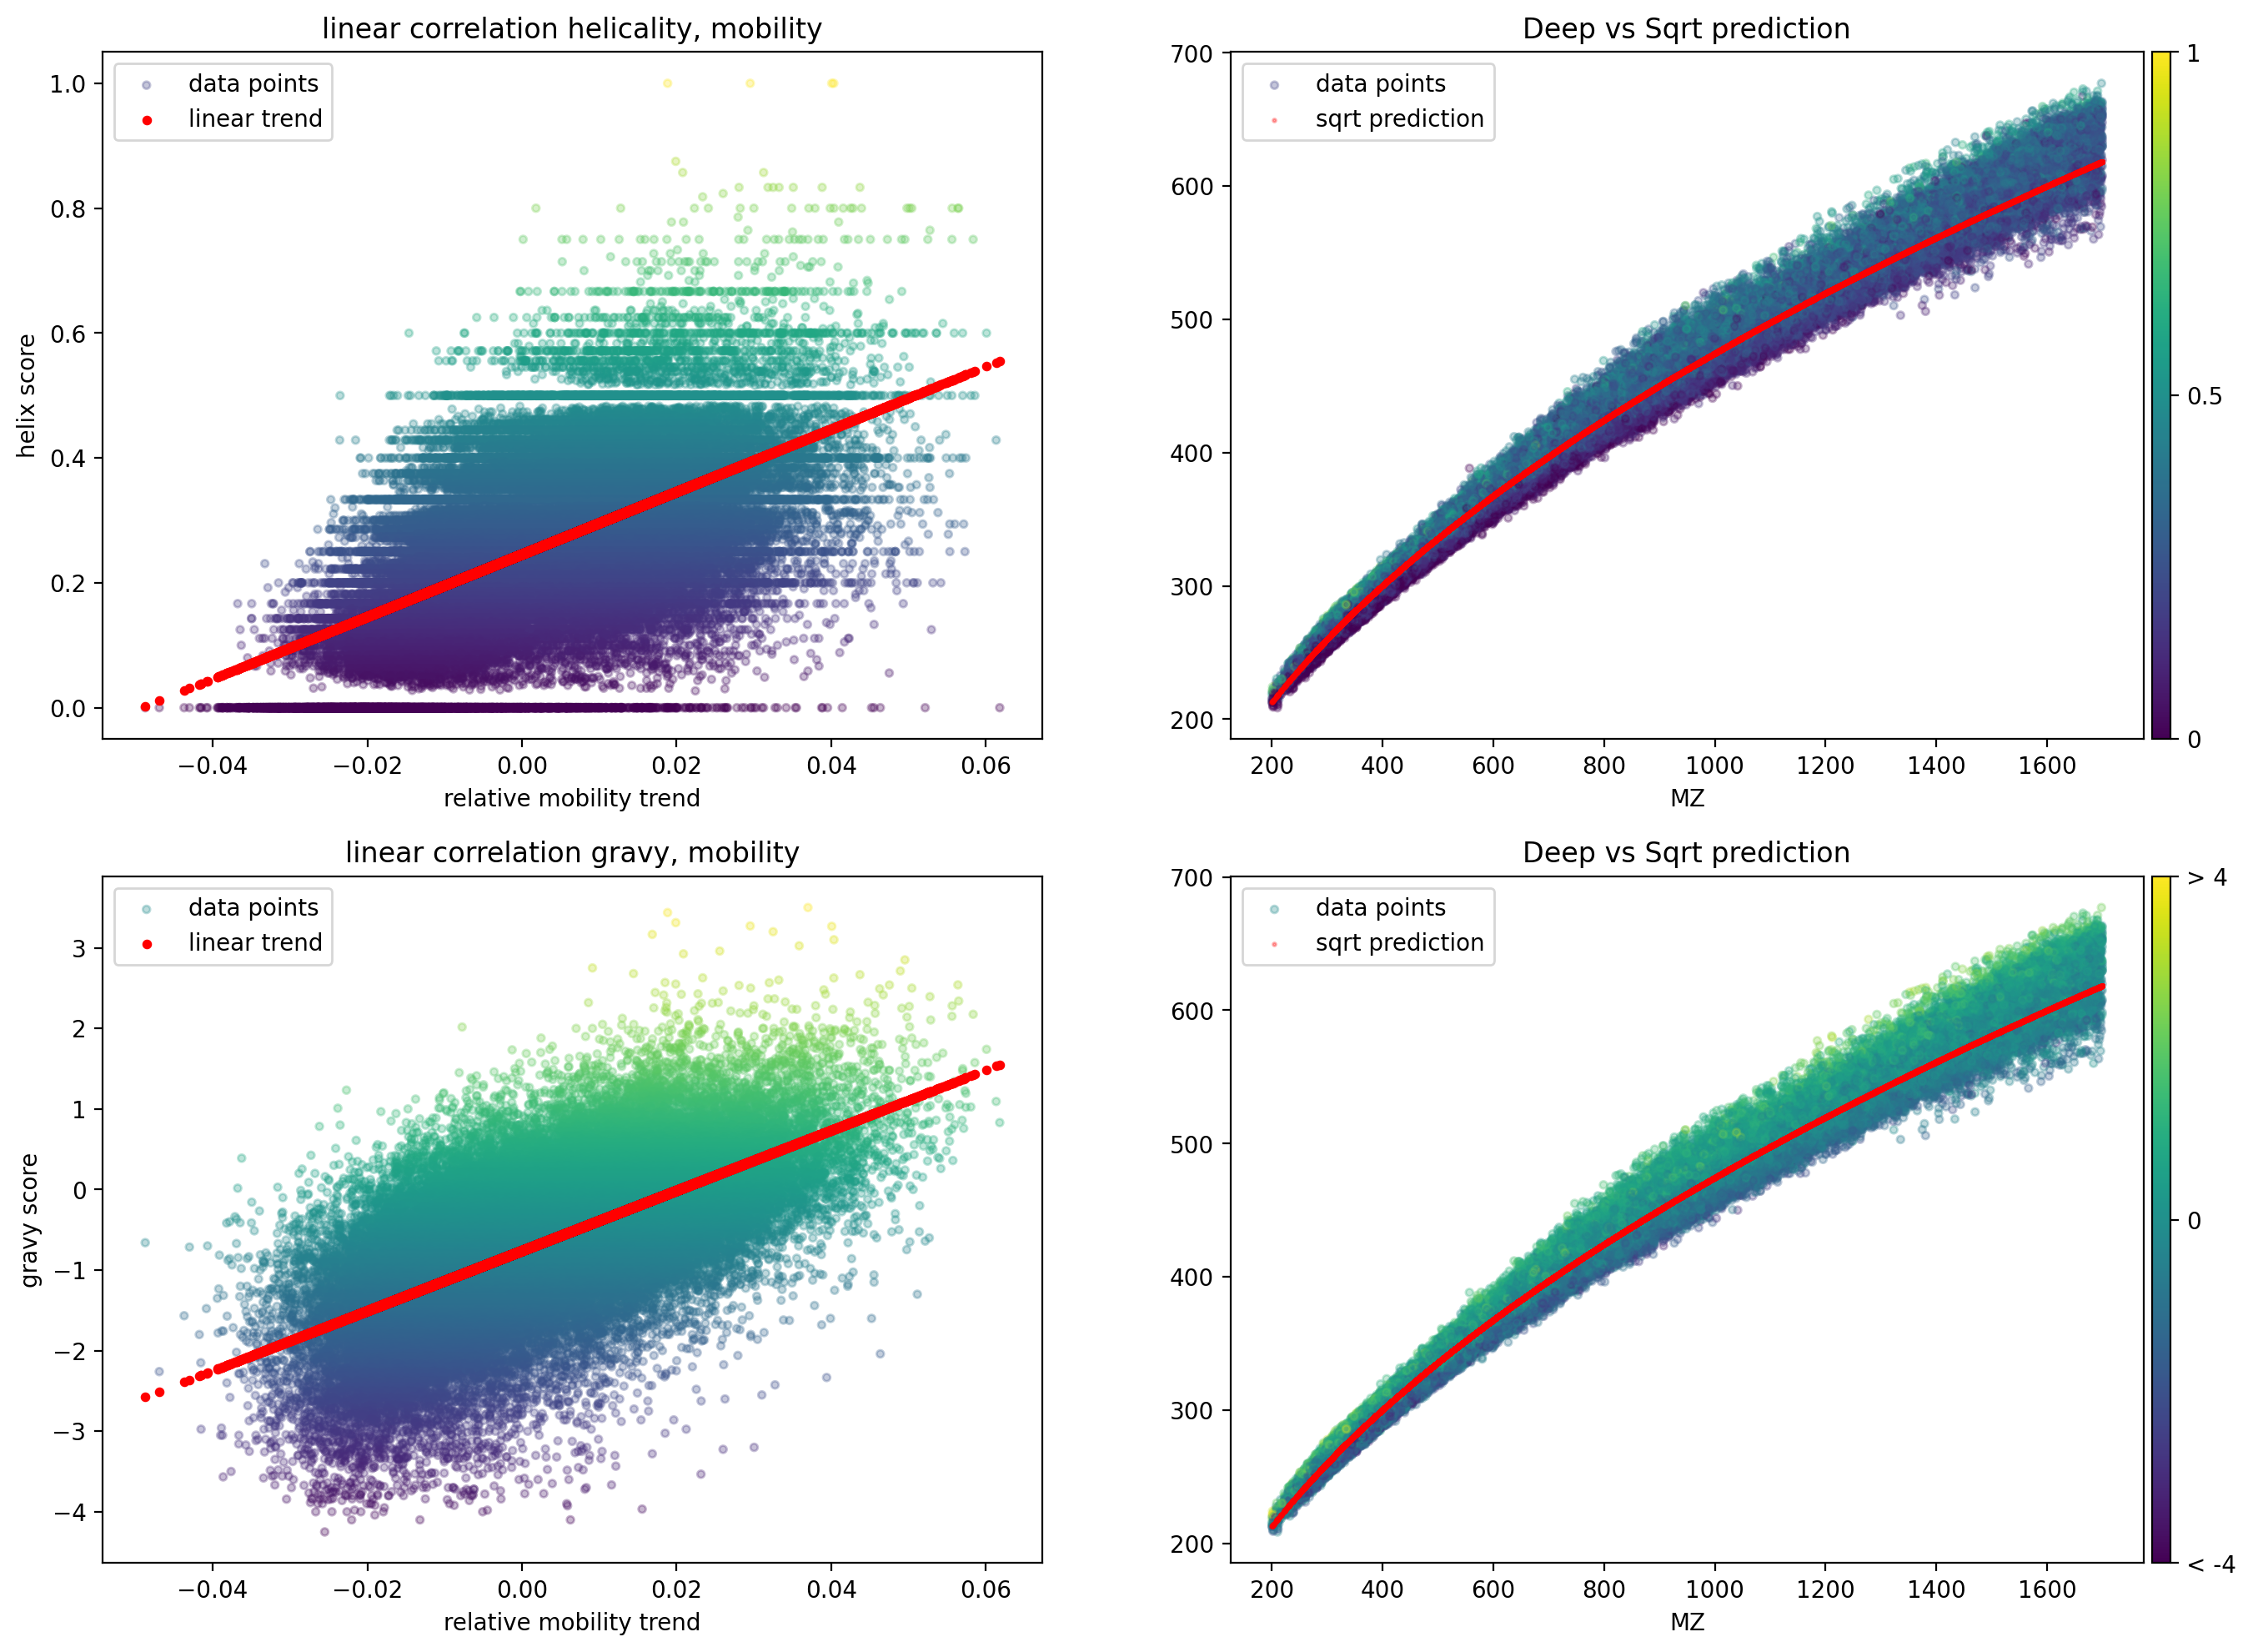

In [6]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# create the plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,12), dpi=200)

ax1.set_title('linear correlation helicality, mobility')
ax1.set_ylabel('helix score')
ax1.set_xlabel('relative mobility trend')
ax2.set_xlabel('MZ')
ax2.set_title('Deep vs Sqrt prediction')

im1 = ax1.scatter(charge_2.deep_normalized, charge_2.helix, c=charge_2.helix, alpha=.3, s=10, label='data points')
im1 = ax1.scatter(charge_2.deep_normalized, y_line_helix, s=10, c='red', label='linear trend')

im2 = ax2.scatter(charge_2.mz, charge_2.ccs_predicted_gru, s=10, c=charge_2.helix - np.mean(data.gravy), alpha=.3, label='data points')
im2 = ax2.scatter(charge_2.mz, charge_2.ccs_predicted_sqrt, s=2, c='red', alpha=.3, label='sqrt prediction')
ax1.legend()
ax2.legend()

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, orientation='vertical', ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1'])

ax3.set_title('linear correlation gravy, mobility')
ax3.set_ylabel('gravy score')
ax3.set_xlabel('relative mobility trend')
ax4.set_xlabel('MZ')
ax4.set_title('Deep vs Sqrt prediction')

im3 = ax3.scatter(charge_2.deep_normalized, charge_2.gravy, c=charge_2.gravy, alpha=.3, s=10, label='data points')
im3 = ax3.scatter(charge_2.deep_normalized, y_line_gravy, s=10, c='red', label='linear trend')

im4 = ax4.scatter(charge_2.mz, charge_2.ccs_predicted_gru, s=10, c=charge_2.gravy, alpha=.3, label='data points')
im4 = ax4.scatter(charge_2.mz, charge_2.ccs_predicted_sqrt, s=2, c='red', alpha=.3, label='sqrt prediction')
ax3.legend()
ax4.legend()

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im3, cax=cax, orientation='vertical', ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['< -4', '0', '> 4'])

plt.show()

As we can observe, our predictor is able to reproduce findings that were already postulated by Chang et al. as well as Meier et al.: Higher gravy and helicality values indeed lead to higher CCS values (at least with respect to our trained predictor). This correlation is by no means perfect, but it lies in the nature of complex interactions that lead to a peptide's 3D structure that they cannot easily be modelled by a simple set of descriptors. Ultimately, this is why a complex function modelling technique like Deep Learning can add something new!